<a href="https://colab.research.google.com/github/Allexxandr/data-analytics-project-100/blob/main/charts_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import seaborn as sns
from dotenv import load_dotenv


In [4]:
def preparing_data():
    """
    Подготавливает данные из API о визитах и регистрациях.

    Загружает переменные окружения, получает данные через API,
    обрабатывает визиты (удаляет ботов, оставляет только последние визиты),
    обрабатывает регистрации и возвращает подготовленные DataFrame'ы.

    Возвращает:
        tuple: (visits_df, regs_df) - обработанные DataFrame'ы с данными о визитах и регистрациях
    """

    load_dotenv()

    DATE_BEGIN = os.getenv('DATE_BEGIN')
    DATE_END = os.getenv('DATE_END')
    API_URL = os.getenv('API_URL')
    # Получаем данные по визитам
    rsp_visits = requests.get(
        f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
    visits_data = rsp_visits.json()
    visits_df = pd.DataFrame(visits_data)

    # Обработка данных о визитах
    visits_df = visits_df[visits_df['user_agent'] != 'bot']
    visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
    visits_df = visits_df.sort_values(by=['datetime']).drop_duplicates(
        subset=['visit_id'], keep='last')
    visits_df['date_group'] = visits_df['datetime'].dt.date

    # Получаем данные по регистрациям
    rsp_regs = requests.get(f'{API_URL}/registrations',
                            params={'begin': DATE_BEGIN, 'end': DATE_END})
    data_regs = rsp_regs.json()
    regs_df = pd.DataFrame(data_regs)

    # Обработка данных о регистрациях
    regs_df['datetime'] = pd.to_datetime(regs_df['datetime'])
    regs_df['date_group'] = regs_df['datetime'].dt.date

    return visits_df, regs_df

In [5]:
def merge_dataframes():
    """
    Объединяет датафреймы с данными о посещениях, регистрациях и рекламе.

    Выполняет следующие действия:
    1. Группировку данных по платформам и датам
    2. Расчет конверсии
    3. Добавление данных о рекламе
    4. Сохранение результатов в JSON файлы

    Параметры:
        None

    Возвращает:
        pd.DataFrame: результирующий DataFrame с объединенными данными

    """
    visits_df, regs_df = preparing_data()
    # Группировка данных по платформам и датам
    regs_grouped = regs_df.groupby(
        ['date_group', 'platform']).size().reset_index(name='registrations')
    visits_grouped = visits_df.groupby(
        ['date_group', 'platform']).size().reset_index(name='visits')

    # Конвертация типов
    regs_grouped['date_group'] = pd.to_datetime(regs_grouped['date_group'])
    visits_grouped['date_group'] = pd.to_datetime(visits_grouped['date_group'])

    # Объединение данных с учетом конверсии
    merged_df = pd.merge(regs_grouped, visits_grouped,
                         on=['date_group', 'platform'],
                         how='inner')

    # Приведение к целочисленному типу
    merged_df['registrations'] = merged_df['registrations'].astype(int)
    merged_df['visits'] = merged_df['visits'].astype(int)

    # Расчет конверсии
    merged_df['conversion'] = np.where(
        merged_df['visits'] == 0, 0,
        merged_df['registrations'] / merged_df['visits'] * 100
    )

    # Выбор необходимых колонок
    merged_df = merged_df[['date_group', 'platform', 'visits',
                          'registrations', 'conversion']]

    # Сохранение промежуточных данных
    merged_df.to_json('./conversion.json')

    # Добавление данных по рекламе
    ads_df = pd.read_csv('ads.csv')
    ads_df['date'] = pd.to_datetime(ads_df['date'])
    ads_df['date_group'] = ads_df['date'].dt.date

    # Группировка данных по рекламе
    ads_grouped = ads_df.groupby(['date_group', 'utm_campaign'])[
        'cost'].sum().reset_index()
    ads_grouped['date_group'] = pd.to_datetime(ads_grouped['date_group'])

    # Объединение с данными о конверсии
    result_df = pd.merge(
        merged_df.assign(date_group=merged_df['date_group']),
        ads_grouped,
        on='date_group',
        how='left'
    )

    # Заполнение пропущенных значений
    result_df.fillna({'cost': 0, 'utm_campaign': 'none'}, inplace=True)

    # Сохранение финального результата
    result_df.to_json('ads.json', orient='records')

    return result_df


In [14]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os

def charts():
    """
    Создает все необходимые визуализации данных.

    Функция создает следующие графики:
    1. Общие визиты по дням
    2. Визиты по платформам (стековый график)
    3. Общие регистрации по дням
    4. Регистрации по платформам (стековый график)
    5. Общая конверсия
    6. Конверсия по платформам
    7. Стоимость рекламных кампаний
    8. Визиты и регистрации с выделением рекламных кампаний

    Все графики сохраняются в директории 'charts' с высоким разрешением (dpi=300).
    """
    result_df = merge_dataframes()
    # Создаем директорию для сохранения графиков
    chart_dir = 'charts'
    if not os.path.exists(chart_dir):
        os.makedirs(chart_dir)

    # Группировка данных по дате
    result_df['date_group'] = pd.to_datetime(
        result_df['date_group'], unit='ms')
    daily_visits = result_df.groupby(
        'date_group')['visits'].sum().reset_index()

    # График общих визитов
    plt.figure(figsize=(45, 15))
    plt.bar(daily_visits['date_group'], daily_visits['visits'],
            color='lightblue', label='Daily Visits')
    plt.title('Total Visits', fontsize=14)
    plt.xlabel('date_group', fontsize=12)
    plt.ylabel('Visits', fontsize=12)
    plt.xticks(daily_visits['date_group'], rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xlim(daily_visits['date_group'].iloc[0],
             daily_visits['date_group'].iloc[-1])
    for x, y in zip(daily_visits['date_group'], daily_visits['visits']):
        plt.text(x, y + 0.02 *
                 max(daily_visits['visits']), str(y), ha='center', fontsize=9)
    plt.tight_layout()
    plt.savefig('./charts/total_visits.png', dpi=300, bbox_inches='tight')


    # График визитов по платформам
    result_df_no_bot = result_df[result_df['platform'] != 'bot']
    stacked_data_visits = result_df_no_bot.pivot_table(
        index='date_group',
        columns='platform',
        values='visits',
        aggfunc='sum',
        fill_value=0
    )
    plt.figure(figsize=(22, 10))
    stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.xlabel('date_group')
    plt.ylabel('visits')
    plt.title('Visits by Platform')
    stacked_data_visits.index = pd.to_datetime(stacked_data_visits.index)
    first_of_month_dates = stacked_data_visits.index[stacked_data_visits.index.day == 1]
    first_of_month_dates_positions = [
        stacked_data_visits.index.get_loc(date) for date in first_of_month_dates]
    plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime(
        '%Y-%m'), rotation=0, ha='left')
    plt.grid(alpha=0.5)
    plt.legend(title='Platform')
    plt.tight_layout()
    plt.savefig('./charts/visits_by_platform.png')


    # График общих регистраций
    daily_registrations = result_df.groupby(
        'date_group')['registrations'].sum().reset_index()
    plt.figure(figsize=(45, 15))
    plt.bar(daily_registrations['date_group'], daily_registrations['registrations'],
            color='lightblue', label='Daily Registrations')
    plt.title('Total Registrations', fontsize=14)
    plt.xlabel('date_group', fontsize=12)
    plt.ylabel('registrations', fontsize=12)
    plt.xticks(daily_registrations['date_group'], rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xlim(daily_registrations['date_group'].iloc[0],
             daily_registrations['date_group'].iloc[-1])
    for x, y in zip(daily_registrations['date_group'], daily_registrations['registrations']):
        plt.text(x, y + 0.02 * max(daily_registrations['registrations']), str(y),
                 ha='center', fontsize=9)
    plt.tight_layout()
    plt.savefig('./charts/total_registrations.png',
                dpi=300, bbox_inches='tight')


    # График регистраций по платформам
    stacked_data_registrations = result_df_no_bot.pivot_table(
        index='date_group',
        columns='platform',
        values='registrations',
        aggfunc='sum',
        fill_value=0
    )
    plt.figure(figsize=(22, 10))
    stacked_data_registrations.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.xlabel('date_group')
    plt.ylabel('registrations')
    plt.title('Registrations by Platform')
    stacked_data_registrations.index = pd.to_datetime(
        stacked_data_registrations.index)
    first_of_month_dates = stacked_data_registrations.index[
        stacked_data_registrations.index.day == 1]
    first_of_month_dates_positions = [stacked_data_registrations.index.get_loc(
        date) for date in first_of_month_dates]
    plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime('%Y-%m'),
               rotation=0, ha='left')
    plt.grid(alpha=0.5)
    plt.legend(title='Platform')
    plt.tight_layout()
    plt.savefig('./charts/registrations_by_platform.png')


    # График общей конверсии
    result_df_weekly_no_bot = result_df_no_bot[
        (result_df_no_bot['date_group'] >= '2023-03-01') &
        (result_df_no_bot['date_group'] <= '2023-05-01')
    ]
    daily_conversion_no_bot = (
        result_df_weekly_no_bot.groupby('date_group')
        .apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)
    ).reset_index(name='conversion_rate')
    plt.figure(figsize=(14, 6))
    plt.plot(daily_conversion_no_bot['date_group'], daily_conversion_no_bot['conversion_rate'],
             marker='o', color='blue', label='Conversion Rate')
    for x, y in zip(daily_conversion_no_bot['date_group'], daily_conversion_no_bot['conversion_rate']):
        plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)
    weekly_ticks = pd.date_range(
        start='2023-03-01', end='2023-05-01', freq='7D')
    plt.title('Overall Conversion', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Conversion (%)', fontsize=12)
    plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'),
               rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('./charts/overall_conversion.png',
                dpi=300, bbox_inches='tight')


    # График конверсии по платформам
    result_df_no_bot = result_df[result_df['platform'] != 'bot']
    platforms_no_bot = result_df_no_bot['platform'].unique()
    for platform in platforms_no_bot:
        plt.figure(figsize=(14, 6))
        platform_data = result_df_no_bot[result_df_no_bot['platform'] == platform]
        plt.plot(platform_data['date_group'], platform_data['conversion'],
                 marker='o', color='blue', label=f'Conversion ({platform})')
        for x, y in zip(platform_data['date_group'], platform_data['conversion']):
            plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)
        weekly_ticks = pd.date_range(
            start='2023-03-01', end='2023-09-01', freq='7D')
        plt.title(f'Conversion {platform.capitalize()}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Conversion (%)', fontsize=12)
        plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'),
                   rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='both', linestyle='-', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig(f'./charts/conversion_by_platform.png',
                    dpi=300, bbox_inches='tight')


    # График стоимости рекламы
    daily_cost = result_df.groupby('date_group')['cost'].sum().reset_index()
    plt.figure(figsize=(45, 15))
    plt.plot(daily_cost['date_group'], daily_cost['cost'], marker='o',
             color='lightgreen', label='Daily Advertising Cost')
    for x, y in zip(daily_cost['date_group'], daily_cost['cost']):
        plt.text(x, y + 0.5, f"{y:.2f} RUB", ha='center', fontsize=9)
    plt.title('Aggregated Ad Campaign Costs (by day)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cost (RUB)', fontsize=12)
    plt.xticks(daily_cost['date_group'], daily_cost['date_group'].dt.strftime('%Y-%m-%d'),
               rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.grid(axis='x', linestyle='-', alpha=0.7)
    plt.tight_layout()
    plt.savefig('./charts/aggregated_ad_campaign_costs.png',
                dpi=300, bbox_inches='tight')


    # График визитов с выделением рекламных кампаний
    daily_visits = result_df.groupby(
        'date_group')['visits'].sum().reset_index()
    mean_visits = daily_visits['visits'].mean()
    plt.figure(figsize=(45, 15))
    plt.plot(daily_visits['date_group'], daily_visits['visits'], marker='o',
             color='blue', label='Daily Visits')
    plt.axhline(mean_visits, color='red', linestyle='--', linewidth=1.5,
                label='Average number of visits')
    campaigns = result_df['utm_campaign'].unique()
    campaign_colors = {campaign: color for campaign,
                       color in zip(campaigns, cm.tab20.colors)}
    for campaign in campaigns:
        if campaign != 'none':
            campaign_data = result_df[result_df['utm_campaign'] == campaign]
            if not campaign_data.empty:
                start_date = campaign_data['date_group'].min()
                end_date = campaign_data['date_group'].max()
                plt.axvspan(
                    start_date, end_date, alpha=0.3,
                    color=campaign_colors[campaign], label=f'Campaign: {campaign}'
                )
    plt.title('Visits during marketing active days', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Visits', fontsize=12)
    plt.xticks(daily_visits['date_group'], daily_visits['date_group'].dt.strftime('%Y-%m-%d'),
               rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('./charts/visits_during_marketing_active_days.png',
                dpi=300, bbox_inches='tight')


    # График регистраций с выделением рекламных кампаний
    daily_registrations = result_df.groupby(
        'date_group')['registrations'].sum().reset_index()
    mean_registrations = daily_registrations['registrations'].mean()
    plt.figure(figsize=(45, 15))
    plt.plot(daily_registrations['date_group'], daily_registrations['registrations'],
             marker='o', color='green', label='Daily Registrations')
    plt.axhline(mean_registrations, color='red', linestyle='--', linewidth=1.5,
                label='Average number of registrations')
    campaigns = result_df['utm_campaign'].unique()
    campaign_colors = {campaign: color for campaign,
                       color in zip(campaigns, cm.tab20.colors)}
    for campaign in campaigns:
        if campaign != 'none':
            campaign_data = result_df[result_df['utm_campaign'] == campaign]
            if not campaign_data.empty:
                start_date = campaign_data['date_group'].min()
                end_date = campaign_data['date_group'].max()
                plt.axvspan(
                    start_date, end_date, alpha=0.3,
                    color=campaign_colors[campaign], label=f'Campaign: {campaign}'
                )
    plt.title('Registrations during marketing active days', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Registrations', fontsize=12)
    plt.xticks(daily_registrations['date_group'],
               daily_registrations['date_group'].dt.strftime('%Y-%m-%d'),
               rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('./charts/registrations_during_marketing_active_days.png',
                dpi=300, bbox_inches='tight')
    plt.show()



<ipython-input-14-2368b9ea1480>:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)


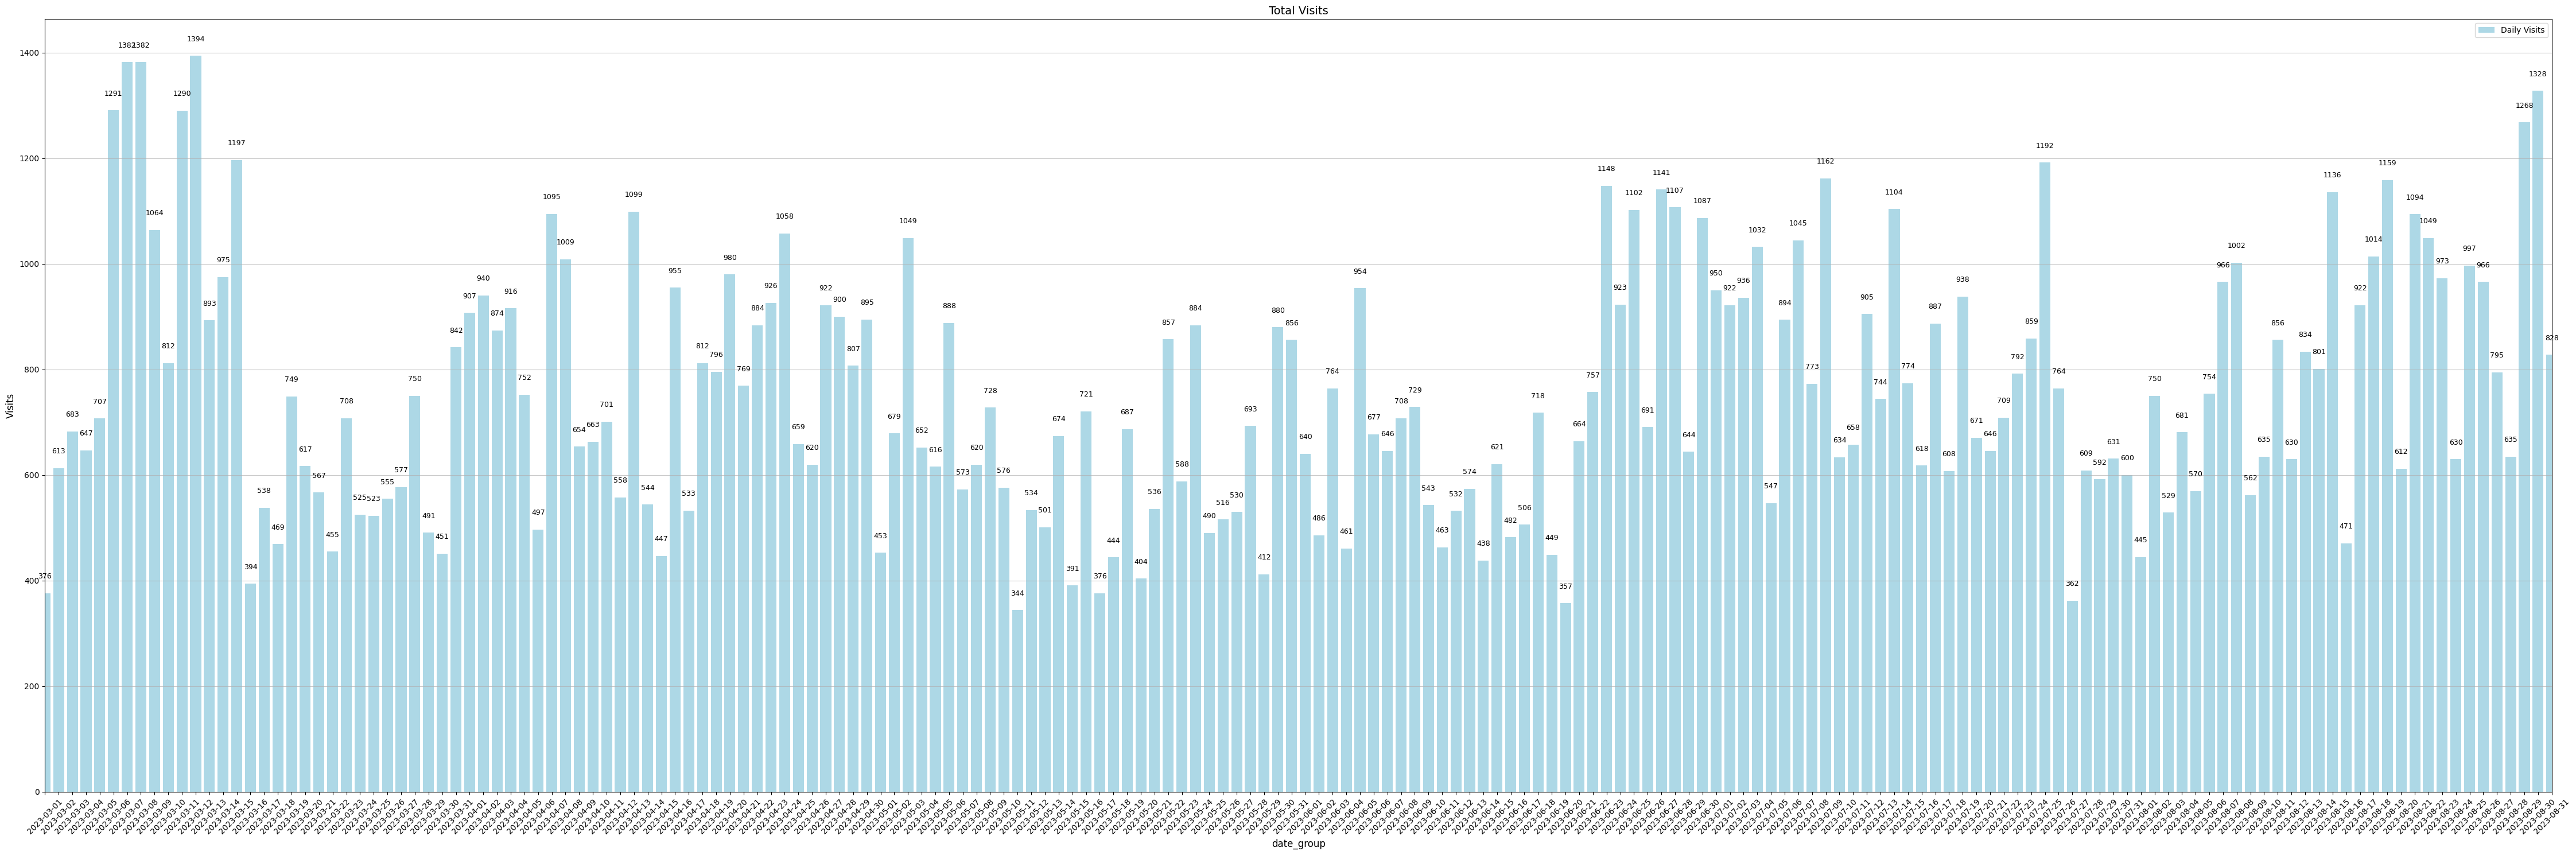

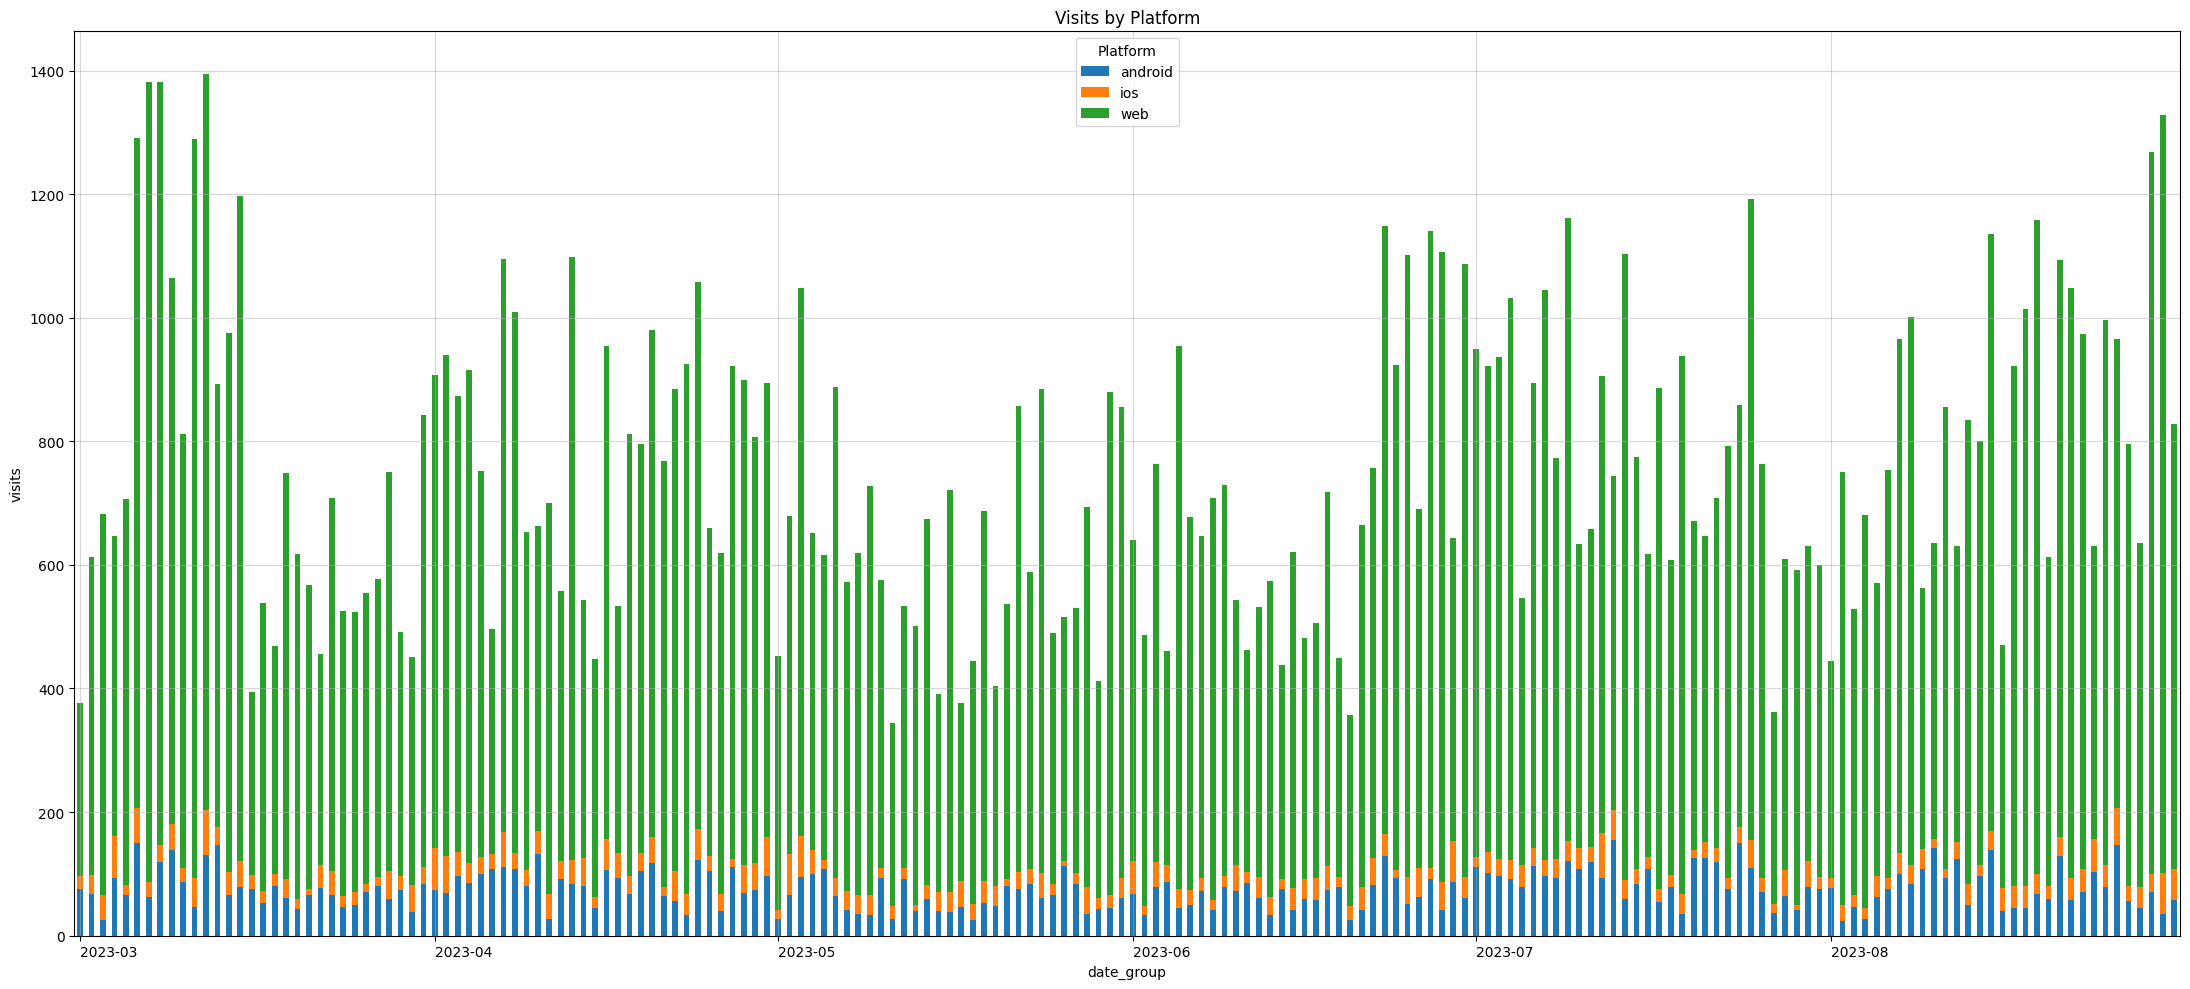

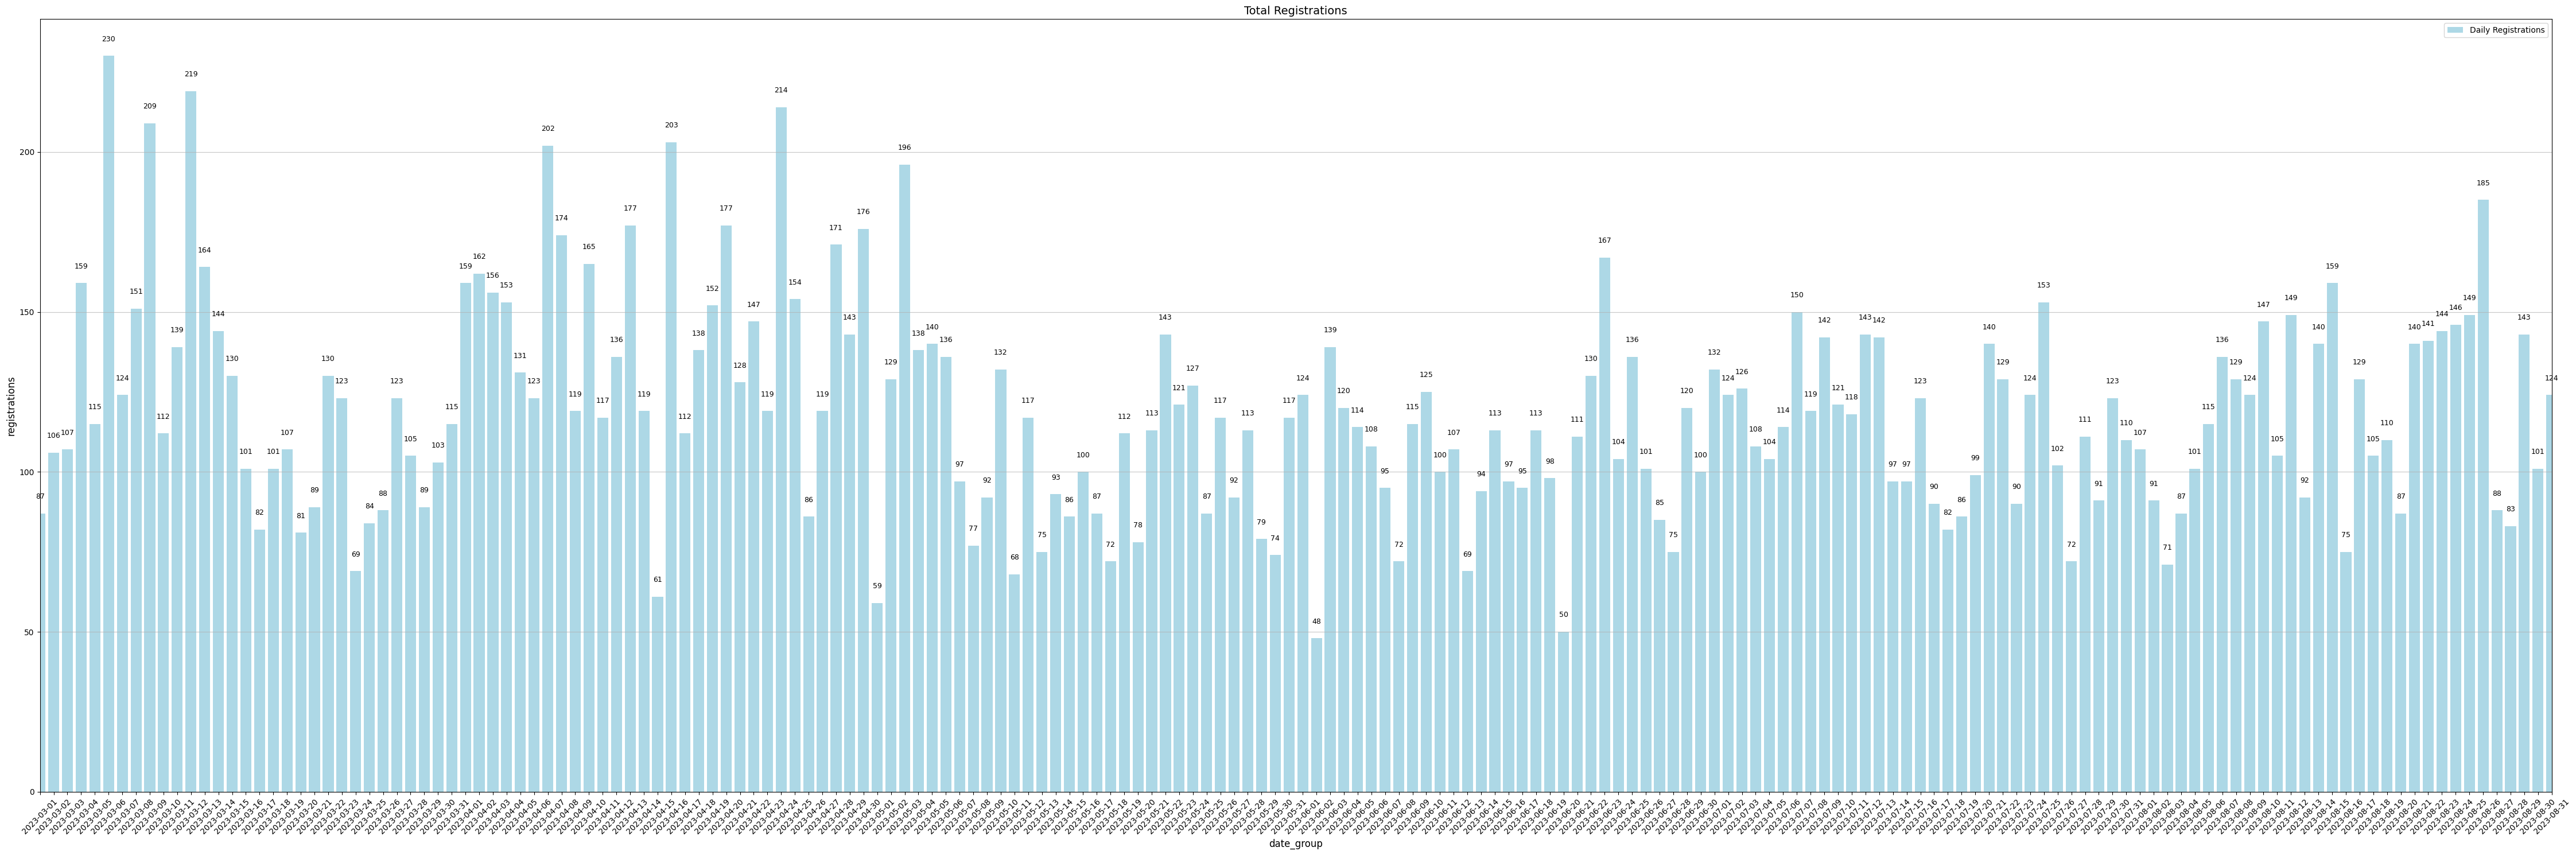

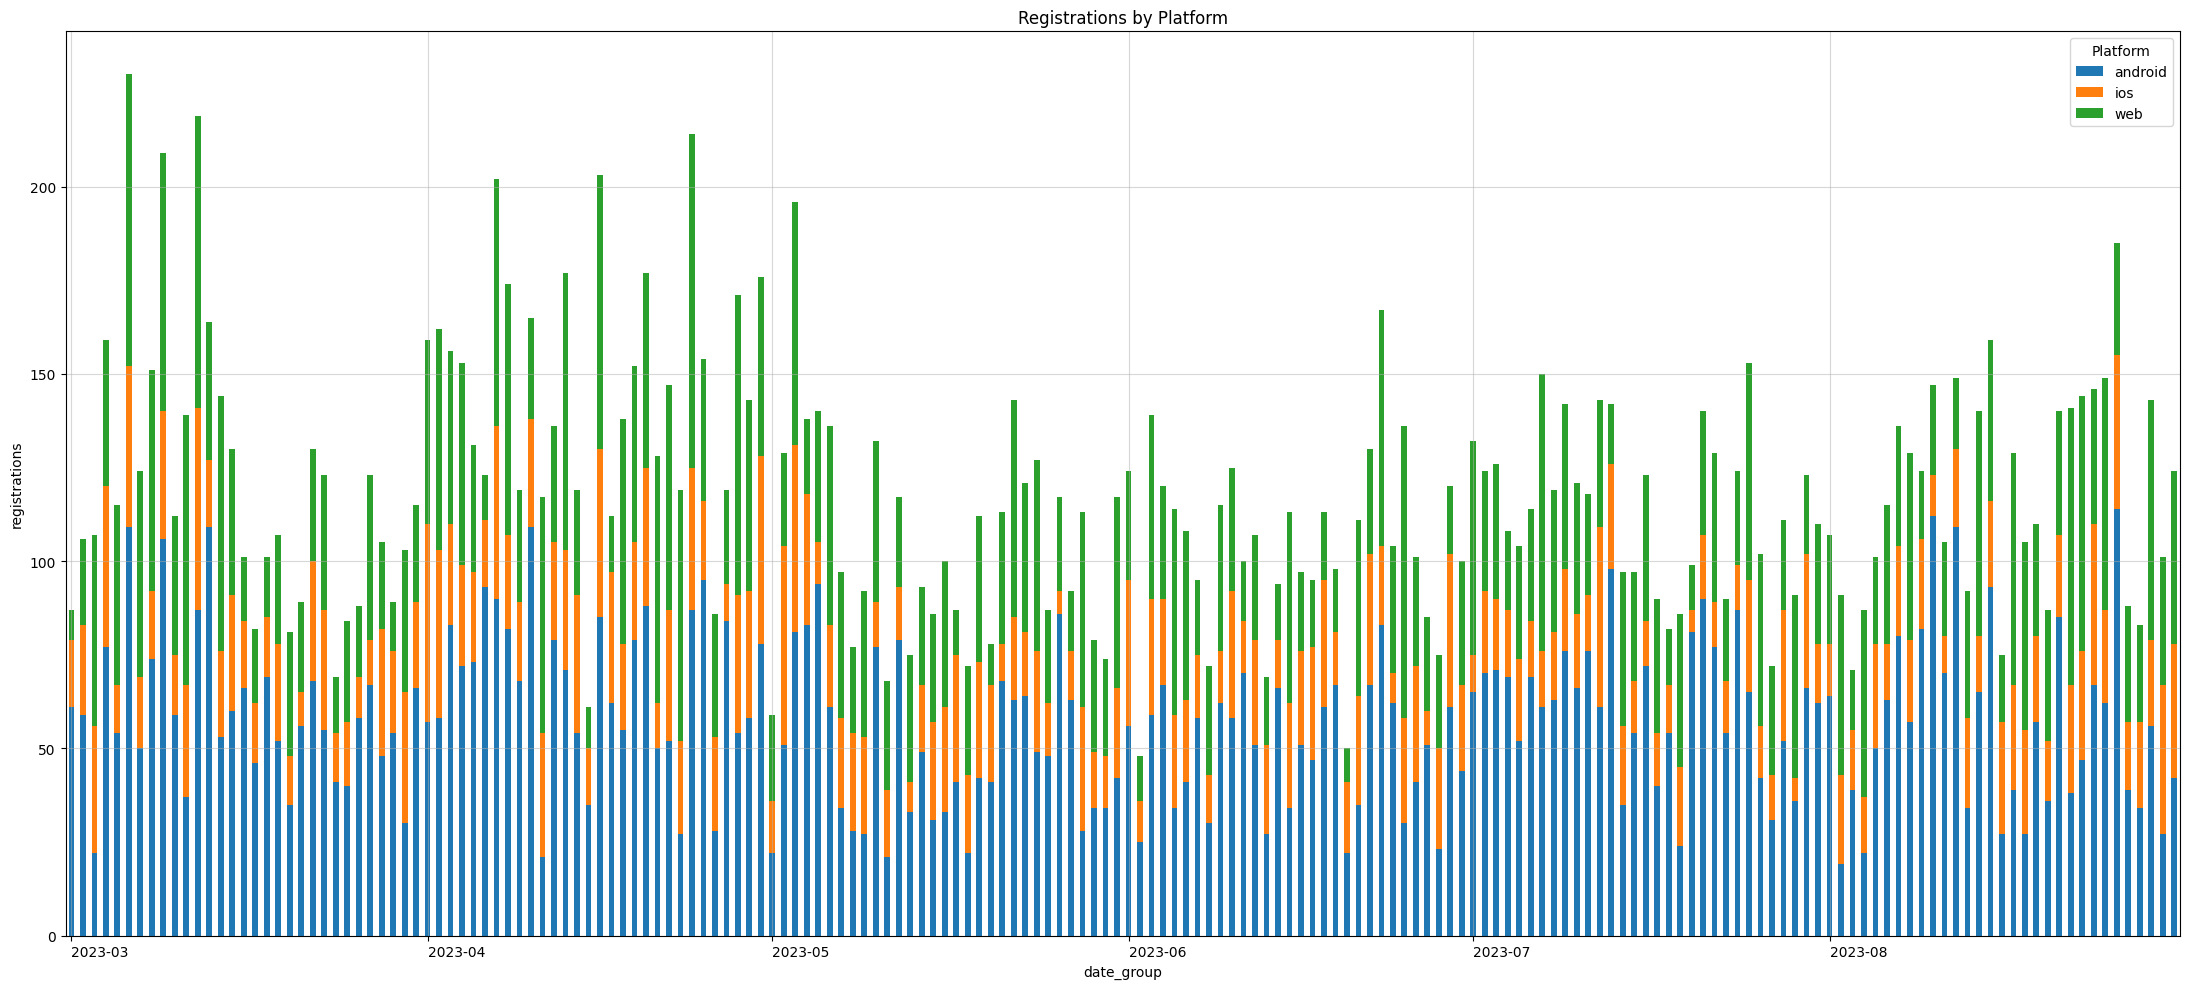

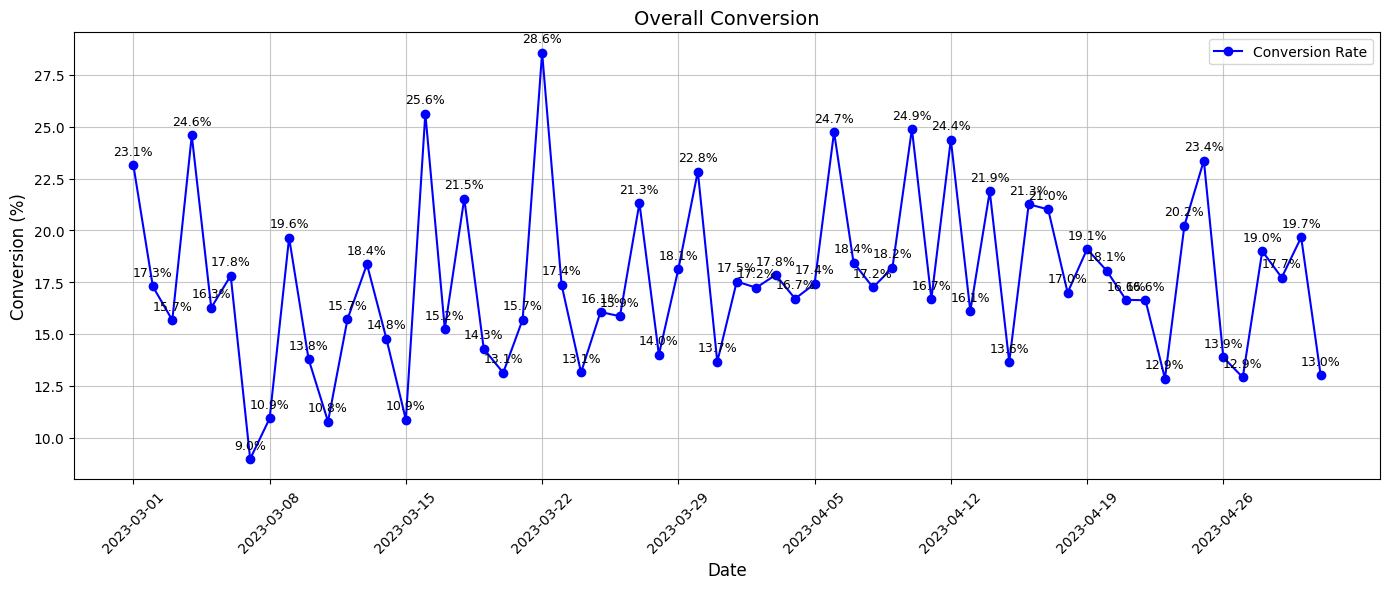

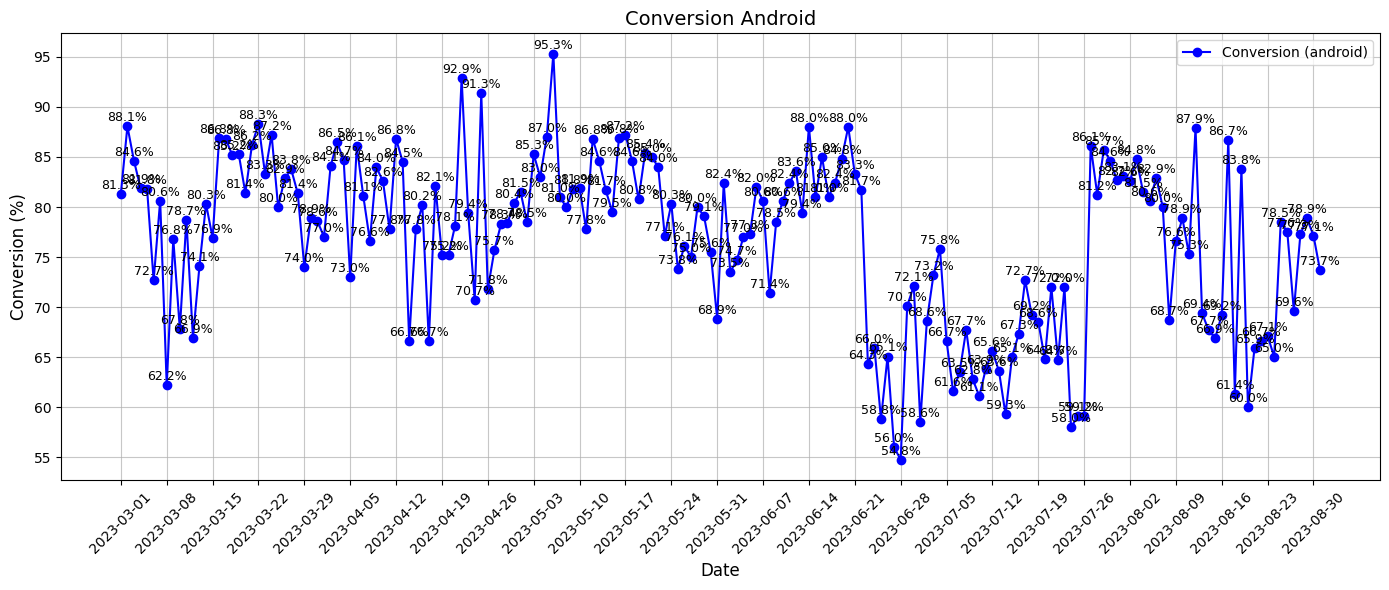

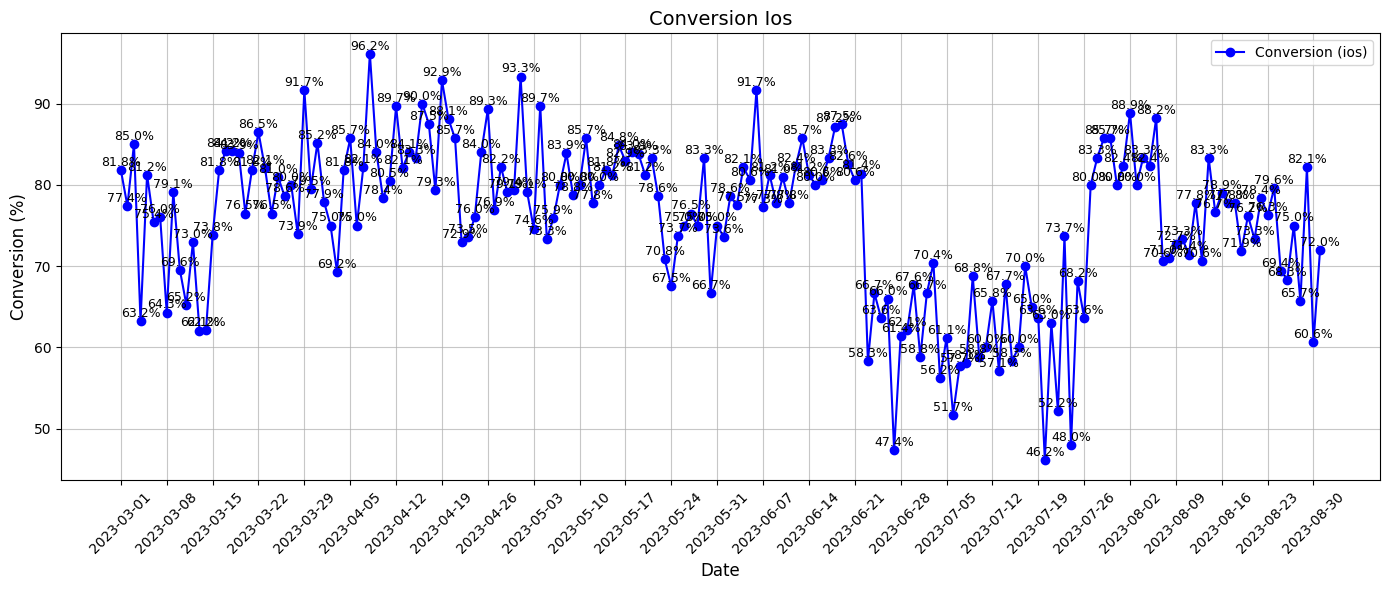

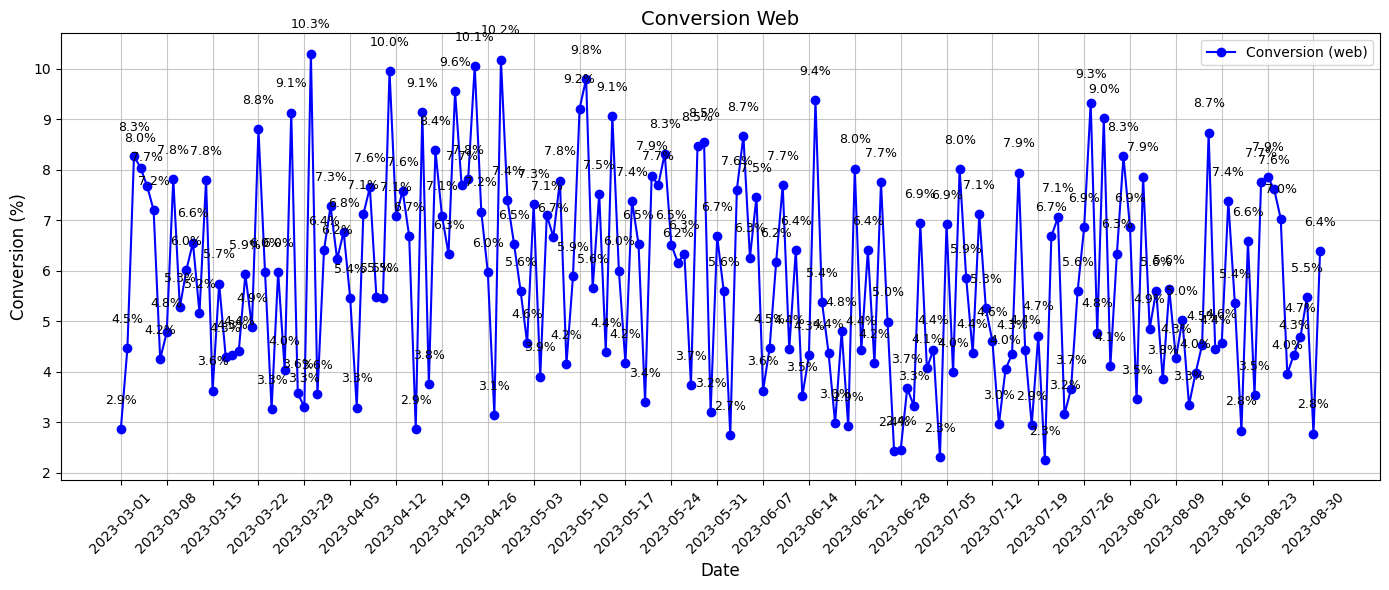

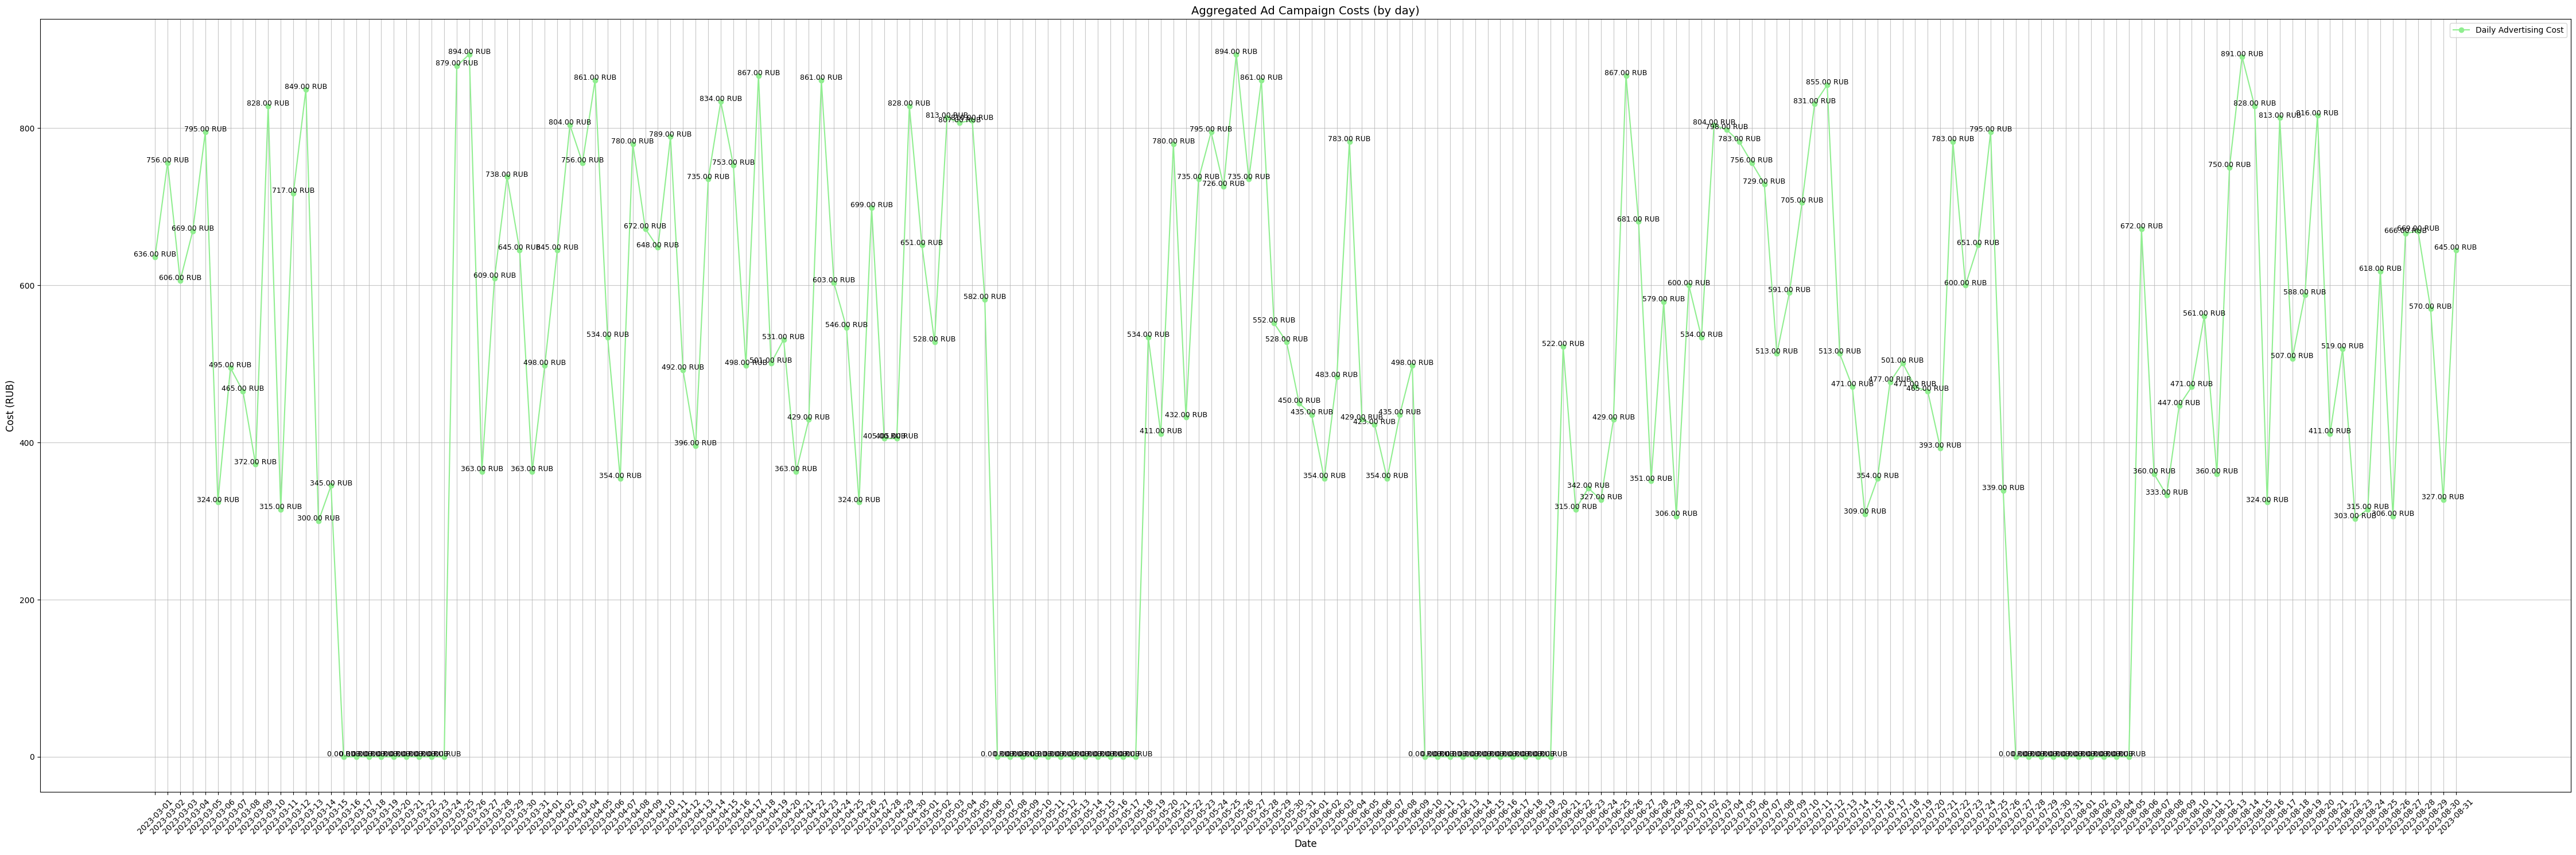

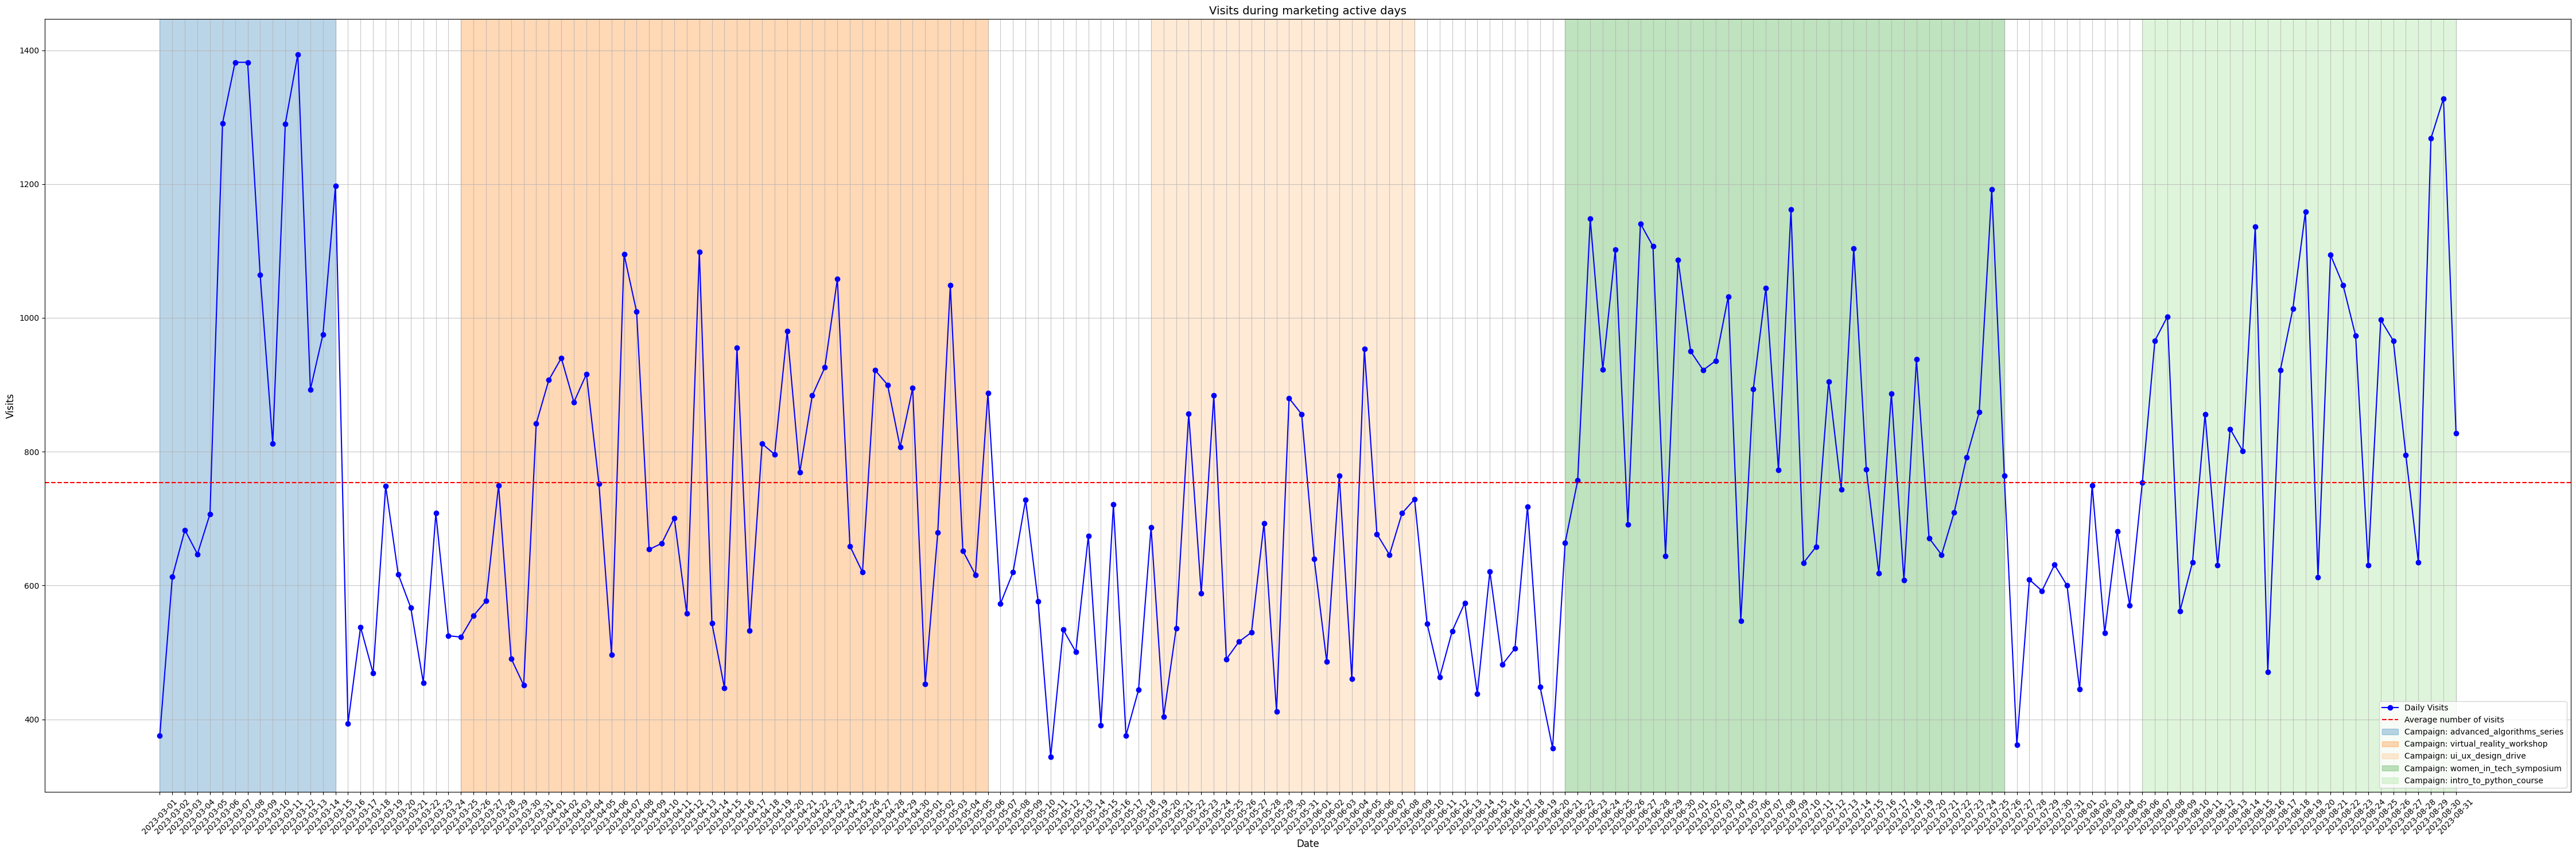

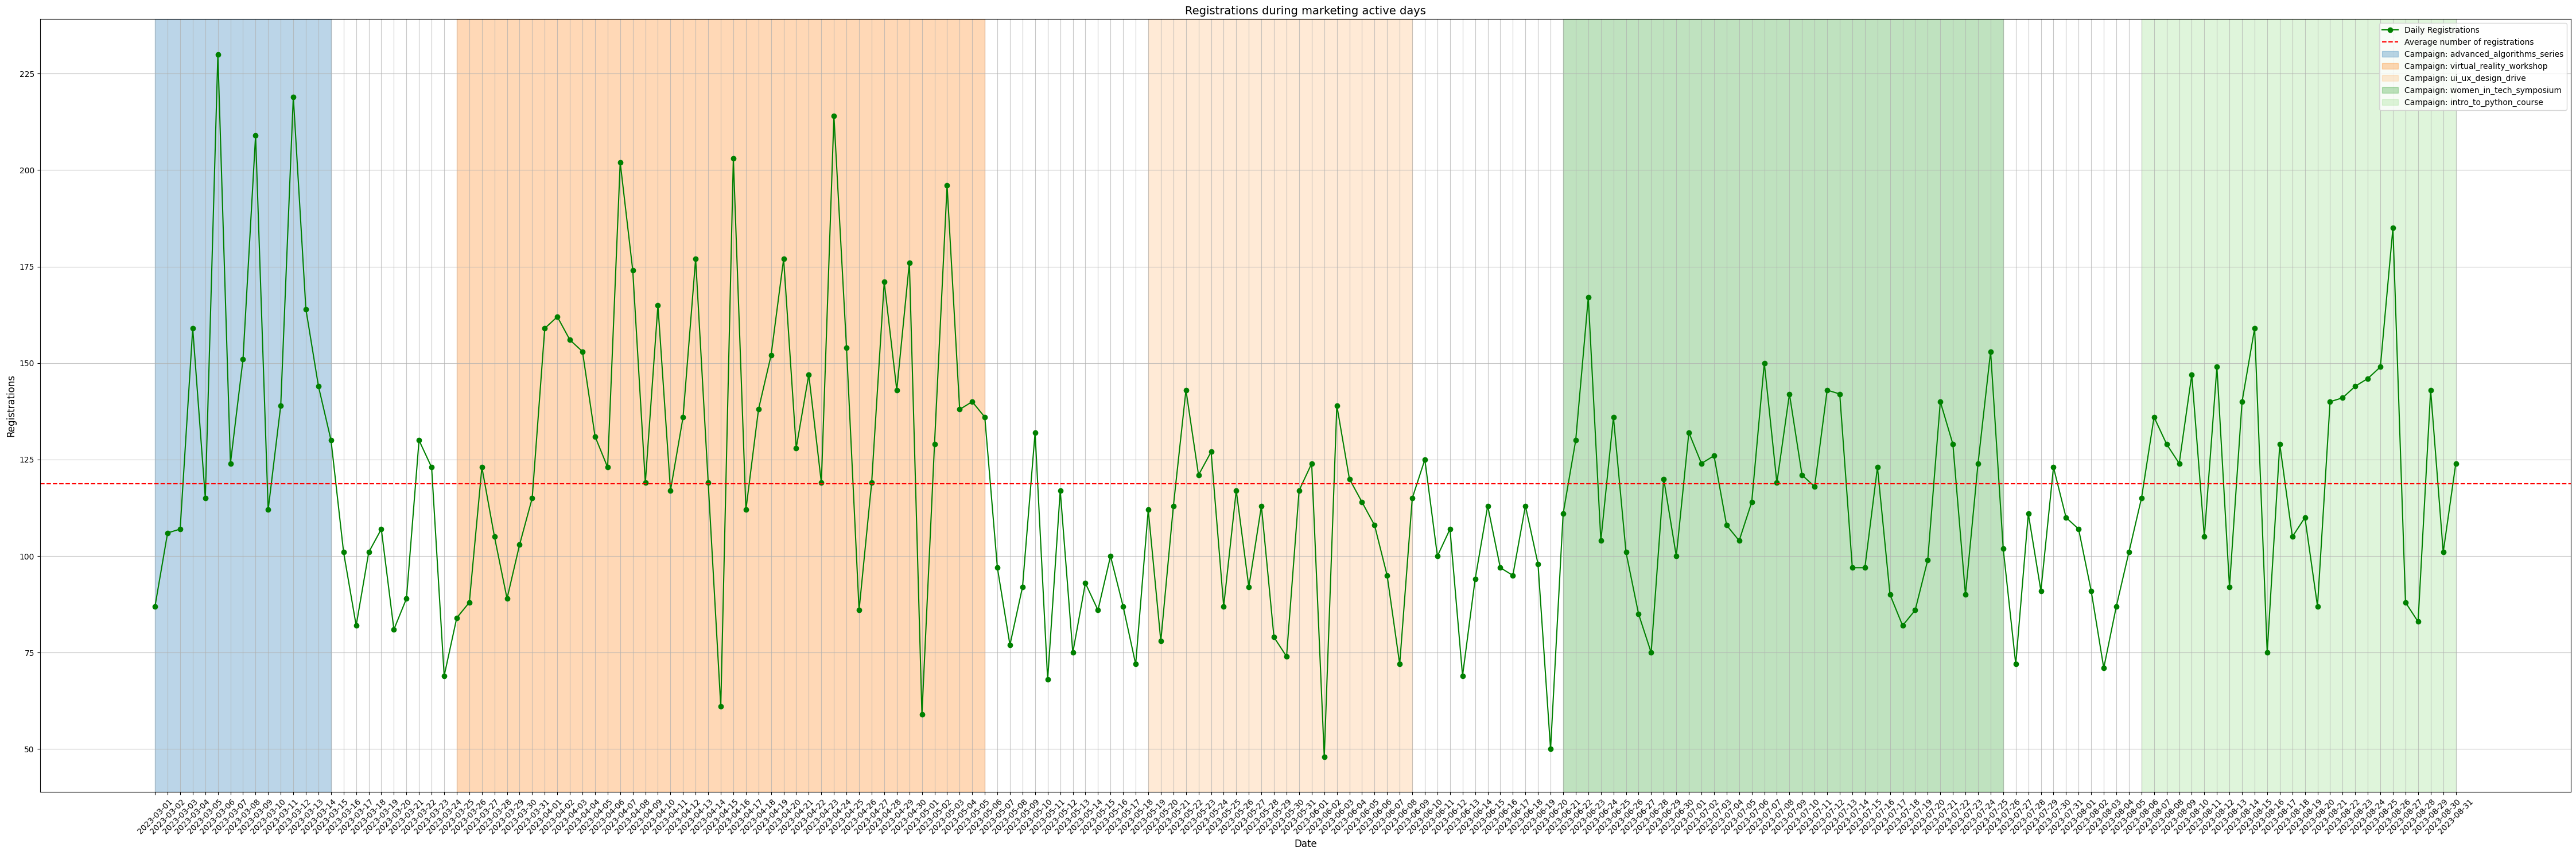

In [15]:
charts()